### Imports

In [28]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
hs_blau = "#22376f"
#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#0645ad", "#800020", "#1EB9E7", ])

### Einlesen der Daten

In [29]:
bevölkerung = pd.read_excel(f"Data\\12411-0012_complete.xlsx", index_col=0)

#read sterbefälle pro monat
sterbefälle_monat = pd.read_excel(f"Data\\sonderauswertung-sterbefaelle_groß.xlsx", sheet_name='D_2016-2022_Monate_AG_Ins') #Datensatz ist selbst zusammengebaut
sterbefälle_monat = sterbefälle_monat[sterbefälle_monat.columns].replace(["-",".","X "],0)
sterbefälle_monat

,Nr.,Jahr,Alter,Januar,Februar,März,April,Mai,Juni,Juli,August,September,Oktober,November,Dezember,Insgesamt
0,35,2020,Insgesamt,84980,80030,87396,83830,75835,72159,73795,78742,74243,79781,85989,108792,985572
1,36,2020,0-15,272,291,313,289,277,275,278,273,277,260,240,261,3306
2,37,2020,15-30,329,330,320,288,311,329,335,357,305,320,309,311,3844
3,38,2020,30-35,248,191,229,221,199,213,249,204,224,206,197,226,2607
4,39,2020,35-40,374,330,332,345,346,308,336,316,318,326,328,402,4061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,387,2000,75-80,12695,11668,10979,10282,10020,9795,9784,9956,9537,10346,10313,10911,126286
353,388,2000,80-85,10350,9692,8954,8351,8124,7919,8018,7948,7977,8702,8806,9370,104211
354,389,2000,85-90,15951,14812,13574,12355,11838,11343,11402,11365,11133,11863,12123,12829,150588
355,390,2000,90-95,9386,8742,7715,7130,6838,6863,6655,6894,6652,7409,7617,8126,90027


### Altersgruppen 90-95 und 95+ zu 90+ zusammenfassen

In [30]:
#Sterbefälle einteilen
#bildet summe aus gruppe 90-95 und gruppe ü 95, ersetzt die 90-95 row damit, benennt sie um und dropt die ü95 reihe.
new_row = (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]) + (sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"])
age_90_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="90-95"]
mehr_95 = sterbefälle_monat.loc[sterbefälle_monat["Alter"]=="95 u. mehr"]

new_row = age_90_95.iloc[0,3:] + mehr_95.iloc[0,3:]
index_95 = list(age_90_95.index)
index_mehr = list(mehr_95.index)

for i in range (len(index_95)):
    new_row = age_90_95.iloc[i,3:] +mehr_95.iloc[i,3:]
    sterbefälle_monat.loc[index_95[i], "Januar":] = new_row
    sterbefälle_monat.drop(index_mehr[i], inplace=True)


sterbefälle_monat['Alter'].replace({'90-95': '90<'}, inplace = True)
sterbefälle_monat = sterbefälle_monat.rename(columns={'Januar': 1,'Februar': 2,'März': 3,'April': 4,'Mai': 5,'Juni': 6,'Juli': 7,'August': 8,'September': 9,'Oktober': 10,'November': 11,'Dezember': 12})


### Beispiel Jahr 2020

In [31]:
print(sterbefälle_monat.loc[sterbefälle_monat["Jahr"]==2020])


    Nr.  Jahr      Alter      1      2      3      4      5      6      7  \
0    35  2020  Insgesamt  84980  80030  87396  83830  75835  72159  73795   
1    36  2020       0-15    272    291    313    289    277    275    278   
2    37  2020      15-30    329    330    320    288    311    329    335   
3    38  2020      30-35    248    191    229    221    199    213    249   
4    39  2020      35-40    374    330    332    345    346    308    336   
5    40  2020      40-45    486    458    508    504    497    469    458   
6    41  2020      45-50    856    803    855    859    803    798    791   
7    42  2020      50-55   1943   1697   1878   1714   1737   1645   1710   
8    43  2020      55-60   3159   3002   3158   3029   3005   2902   2937   
9    44  2020      60-65   4414   4166   4454   4213   4150   3914   4107   
10   45  2020      65-70   5820   5520   6089   5638   5382   5155   5271   
11   46  2020      70-75   6653   6224   6893   6603   6134   5905   5895   

### Altersgruppen in 0-15, 15-30, 30-35, ..., 85-90, 90+ aufteilen

In [32]:
#alle Altersgruppen einteilen
rows = []
x = 0
j = 0
for k in range (1 ,32): 
    x=0
    for i in range(0, 92):
        k2 = k*91
        if i == 0 and k == 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[0]]["Gesamt"] #Gesamtbevölkerung je altersgruppe
        if i == 0 and k != 1:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+(k-1)*92]]["Gesamt"]
        else:
            bevölkerungs_anzahl = bevölkerung.loc[bevölkerung.index[i+((k-1)*92)]]["Gesamt"]

        if ( i < 15):
            x += bevölkerungs_anzahl
            if (i == 14):
                rows.append([1990+k-1,"0 - "+"<{}".format(i+1), x])
                x = 0   

        elif (i >= 15 and  i < 30):
    
            x += bevölkerungs_anzahl
            if i == 29:
                rows.append([1990+k-1,(str(i-14)+" - <"+str(i+1)), x])

            
                x = 0

        elif (i >= 30 and  i < 90):
            j += 1
            x += bevölkerungs_anzahl
            if j == 5:
                rows.append([1990+k-1,(str(i-4)+" - <"+str(i+1)), x])
                j = 0
                x = 0

        elif i == 90:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"90=<", x])
            x = 0

        elif i == 91:
            x += bevölkerungs_anzahl
            rows.append([1990+k-1,"Gesamt", x])
            x=0
       
        

new_df = pd.DataFrame(rows, columns=["Jahr","Alter", "Anzahl"])

### Standardbevölkerung auf 2020 festlegen

In [33]:
standard_bevölkerung = new_df.loc[new_df["Jahr"]==2020]
standard_bevölkerung

,Jahr,Alter,Anzahl
480,2020,0 - <15,11477800
481,2020,15 - <30,13340204
482,2020,30 - <35,5581088
483,2020,35 - <40,5290876
484,2020,40 - <45,5034888
485,2020,45 - <50,5035860
486,2020,50 - <55,6487224
487,2020,55 - <60,6817318
488,2020,60 - <65,5818137
489,2020,65 - <70,4899104


# Altersbereinigung


### Rohe Sterberate

In [34]:
#rohe sterberate
#loop über jahre
sterberaten_roh = []
for n in range(0,21):
    z = sterbefälle_monat.loc[(sterbefälle_monat["Jahr"]==2020-n)]
    sterberate_gesamt = 0

    # gesamt_bev = standard_bevölkerung.loc[standard_bevölkerung.index[15]][2]
    gesamt_bev = new_df.loc[new_df["Jahr"]==2020-n]["Anzahl"].reset_index(drop= True)

    #loop über altersgruppen
    for i in range(1,16):
        mri = ((z.loc[z.index[i]]["Insgesamt"]) / gesamt_bev[15]) * 100000  #sterberate je altersgruppe
        sterberate_gesamt += mri 


    sterberaten_roh.append([2020-n, sterberate_gesamt])
    sterberate_gesamt = 0

sterberaten_roh = pd.DataFrame(sterberaten_roh, columns=["Jahr", "Sterberate_Roh"])
sterberaten_roh

,Jahr,Sterberate_Roh
0,2020,1185.222335
1,2019,1129.682765
2,2018,1150.184356
3,2017,1126.025519
4,2016,1103.830288
5,2015,1125.880498
6,2014,1069.436380
7,2013,1106.664697
8,2012,1079.907534
9,2011,1061.060976


## Sterberate je Altersgruppe 2000 - 2020

In [35]:
new_df = new_df.loc[new_df["Jahr"]>=2000]

new_df.drop(new_df.loc[new_df['Alter']=="Gesamt"].index, inplace=True)
new_df = new_df.reset_index(drop=True)



In [36]:
new_df

,Jahr,Alter,Anzahl
0,2000,0 - <15,12777242
1,2000,15 - <30,14189948
2,2000,30 - <35,6699839
3,2000,35 - <40,7222828
4,2000,40 - <45,6399197
...,...,...,...
310,2020,70 - <75,3968070
311,2020,75 - <80,3468028
312,2020,80 - <85,3430502
313,2020,85 - <90,1662241


In [37]:



sterbefälle_monat.drop(sterbefälle_monat.loc[sterbefälle_monat['Alter']=="Insgesamt"].index, inplace=True)
sterbefälle_monat = sterbefälle_monat.loc[sterbefälle_monat["Jahr"]>=2000].reset_index(drop=True)


In [38]:
sterbefälle_monat

,Nr.,Jahr,Alter,1,2,3,4,5,6,7,8,9,10,11,12,Insgesamt
0,36,2020,0-15,272,291,313,289,277,275,278,273,277,260,240,261,3306
1,37,2020,15-30,329,330,320,288,311,329,335,357,305,320,309,311,3844
2,38,2020,30-35,248,191,229,221,199,213,249,204,224,206,197,226,2607
3,39,2020,35-40,374,330,332,345,346,308,336,316,318,326,328,402,4061
4,40,2020,40-45,486,458,508,504,497,469,458,495,454,473,461,540,5803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,386,2000,70-75,9576,8819,8517,7974,7959,7688,7667,7973,7490,8283,7917,8572,98435
311,387,2000,75-80,12695,11668,10979,10282,10020,9795,9784,9956,9537,10346,10313,10911,126286
312,388,2000,80-85,10350,9692,8954,8351,8124,7919,8018,7948,7977,8702,8806,9370,104211
313,389,2000,85-90,15951,14812,13574,12355,11838,11343,11402,11365,11133,11863,12123,12829,150588


In [39]:
sterbefälle_monat['Insgesamt']

0        3306
1        3844
2        2607
3        4061
4        5803
        ...  
310     98435
311    126286
312    104211
313    150588
314    116887
Name: Insgesamt, Length: 315, dtype: int64

In [40]:
sterberaten_df = sterbefälle_monat['Insgesamt']/new_df['Anzahl']
sterberaten_df

0      0.000259
1      0.000271
2      0.000389
3      0.000562
4      0.000907
         ...   
310    0.024807
311    0.036414
312    0.030378
313    0.090593
314    0.138542
Length: 315, dtype: float64

In [41]:
a = new_df.loc[new_df["Jahr"]==2020][["Jahr", "Alter", "Anzahl"]]
a = a.Anzahl.to_frame()
a

,Anzahl
300,11477800
301,13340204
302,5581088
303,5290876
304,5034888
305,5035860
306,6487224
307,6817318
308,5818137
309,4899104


In [42]:
empty_df = pd.DataFrame(columns=["Jahr", "Alter", "Insgesamt", "Anzahl", "Sterblichkeit je Altersgruppe"])
empty_df


,Jahr,Alter,Insgesamt,Anzahl,Sterblichkeit je Altersgruppe


In [45]:
for years in range(0,21):
    a = new_df.loc[new_df["Jahr"]==2020-years][["Jahr", "Alter", "Anzahl"]]
    a = a.Anzahl.to_frame()
    a = a.reset_index(drop=True)


    b = sterbefälle_monat.loc[sterbefälle_monat["Jahr"]==2020-years][["Jahr","Alter", "Insgesamt"]].reset_index(drop=True)
    b["Anzahl"] = a.Anzahl


    b["Sterblichkeit je Altersgruppe"] = b.Insgesamt/ b.Anzahl * 100000
    
    # empty_df = empty_df.reset_index(drop=True)
    empty_df  = pd.concat([empty_df, b])

# empty_df
# empty_df.loc[empty_df["Jahr"] == 2020]
empty_df = empty_df.reset_index(drop=True)
empty_df

,Jahr,Alter,Insgesamt,Anzahl,Sterblichkeit je Altersgruppe
0,2020,0-15,3306,11477800,28.803429
1,2020,15-30,3844,13340204,28.815152
2,2020,30-35,2607,5581088,46.711322
3,2020,35-40,4061,5290876,76.754776
4,2020,40-45,5803,5034888,115.255791
...,...,...,...,...,...
310,2000,70-75,98435,3603180,2731.892384
311,2000,75-80,126286,2847234,4435.392384
312,2000,80-85,104211,1473962,7070.127995
313,2000,85-90,150588,1086993,13853.631072


In [57]:
a = empty_df.loc[empty_df["Jahr"]>2017]
a

,Jahr,Alter,Insgesamt,Anzahl,Sterblichkeit je Altersgruppe
0,2020,0-15,3306,11477800,28.803429
1,2020,15-30,3844,13340204,28.815152
2,2020,30-35,2607,5581088,46.711322
3,2020,35-40,4061,5290876,76.754776
4,2020,40-45,5803,5034888,115.255791
5,2020,45-50,9704,5035860,192.69797
6,2020,50-55,20808,6487224,320.75353
7,2020,55-60,36523,6817318,535.738541
8,2020,60-65,50936,5818137,875.469244
9,2020,65-70,67524,4899104,1378.292847


## Plot

AttributeError: 'Rectangle' object has no property 'stacked'

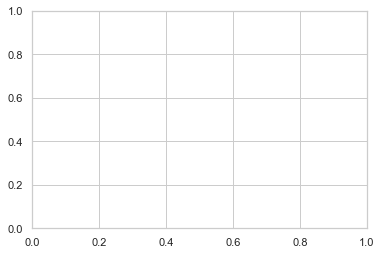

In [54]:
xticks = [i for i in range(2018,2021)]


ax = sns.barplot(x="Jahr",  y='Sterblichkeit je Altersgruppe', data=a)
# plt.legend(labels=['Roh','Bereinigt'],fontsize= 16)
sns.set_theme(style="whitegrid")
plt.xticks(rotation=45)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gcf().set_size_inches(20, 10)

In [61]:
a = a.drop(columns=["Insgesamt", "Anzahl"])
a 

,Jahr,Alter,Sterblichkeit je Altersgruppe
0,2020,0-15,28.803429
1,2020,15-30,28.815152
2,2020,30-35,46.711322
3,2020,35-40,76.754776
4,2020,40-45,115.255791
5,2020,45-50,192.69797
6,2020,50-55,320.75353
7,2020,55-60,535.738541
8,2020,60-65,875.469244
9,2020,65-70,1378.292847


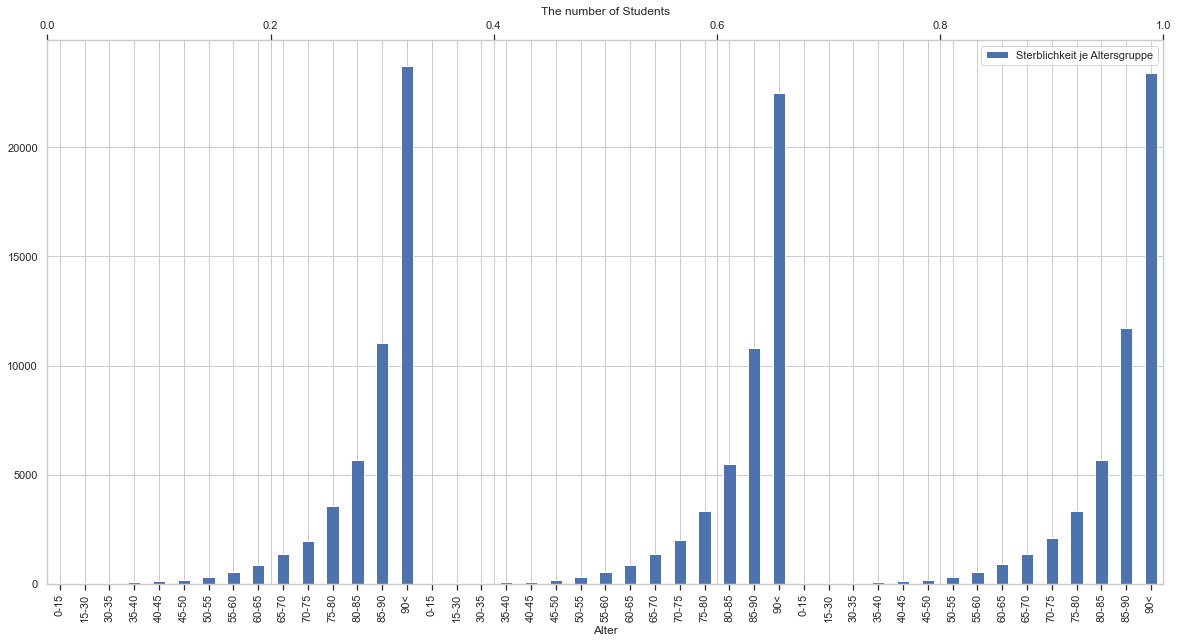

In [66]:
fig = plt.figure()

ax1 = a.plot.bar(x='Alter', y="Sterblichkeit je Altersgruppe", stacked=True, title='The number of Students')
# df.groupby(['name','class'])['vals'].sum().unstack().plot(kind='bar')


plt.gcf().set_size_inches(20, 10)